In [ ]:
from typing import Optional, Sequence

import zarr
import imageio
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
from shapely import affinity


Download and extract the dataset under `data/pusht`.

In [2]:
data_v1 = zarr.open_group("../data/pusht/pusht_cchi_v1.zarr")
data_v2 = zarr.open_group("../data/pusht/pusht_cchi_v2.zarr/")

In [3]:
def get_length(data) -> int:
    return len(data["meta"]["episode_ends"][:].tolist())


def get_element_by_idx(data, key: str, idx: int):
    if idx >= get_length(data):
        raise IndexError
    episode_ends = data["meta"]["episode_ends"][:].tolist()
    start = 0 if idx == 0 else episode_ends[idx - 1]
    end = episode_ends[idx]
    return data["data"][key][start:end]


def get_video_by_idx(data, idx: int):
    return np.array(get_element_by_idx(data, "img", idx), dtype=np.uint8)


def get_identical_indices(data_v1, data_v2):
    """Find out which episode in v2 corresponds to v1."""
    v2_idx_set = set(range(get_length(data_v2)))
    v1_to_v2 = {}

    for i in range(get_length(data_v1)):
        imgs1 = get_video_by_idx(data_v1, i)
        for j in v2_idx_set:
            imgs2 = get_video_by_idx(data_v2, j)
            if imgs1.shape[0] != imgs2.shape[0]:
                continue
            diff = np.abs(imgs1 - imgs2).sum()
            if diff == 0:
                v1_to_v2.update({i: j})
                v2_idx_set.remove(j)
                break
    return v1_to_v2


v1_to_v2 = get_identical_indices(data_v1, data_v2)
v2_exclusives = set(range(get_length(data_v2))) - set(v1_to_v2.values())

In [4]:
def match_identical_initial_state(data_v1, data_v2):
    """Find out whether there are identical initial states as well."""
    matches = []
    for i in range(get_length(data_v1)):
        curr = set()
        s1 = get_element_by_idx(data_v1, "state", i)[0, :]
        for j in range(get_length(data_v2)):
            s2 = get_element_by_idx(data_v2, "state", j)[0, :]
            if (s1 == s2).all():
                curr.add(j)
        matches.append(curr)
    return matches

init_cond_matches = match_identical_initial_state(data_v1, data_v2)

In [ ]:
def plot_kp(points, goal, kp):
    # Plot the points
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], -points[:, 1], color='blue')
    plt.plot(goal[:, 0], -goal[:, 1], color="green")
    plt.scatter(kp[:, 0], -kp[:, 1], color="cyan")

    plt.title("Labeled Points from (9, 2) Array")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')  # Keep aspect ratio equal for better visualization
    plt.show()


In [ ]:
GOAL_POSE = np.array([256, 256, np.pi / 4])
LENGTH = 4
SCALE = 30
SUCCESS_THRESHOLD = 0.95


def get_tee(position: tuple[float, float], angle: float):
    """Adopted from diffusion_policy source code."""
    tee = geometry.Polygon([
        (-LENGTH * SCALE / 2, 0),
        (-LENGTH * SCALE / 2, SCALE),
        (-SCALE / 2, SCALE),
        (-SCALE / 2, SCALE * LENGTH),
        (SCALE / 2, SCALE * LENGTH),
        (SCALE / 2, SCALE),
        (LENGTH * SCALE / 2, SCALE),
        (LENGTH * SCALE / 2, 0),
        (0, 0),
    ])

    return affinity.translate(
        affinity.rotate(tee, angle, origin=(0,0), use_radians=True),
        position[0],
        position[1]
    )


def get_goal():
    return get_tee((256, 256), np.pi / 4)


def get_metric(data, idx: int):
    goal = get_goal()
    goal_area = goal.area
    states = get_element_by_idx(data, "state", idx)
    max_reward = 0
    for state in states:
        curr = get_tee((state[2], state[3]), state[4])
        intersect = goal.intersection(curr).area
        coverage = intersect / goal_area
        reward = np.clip(coverage / SUCCESS_THRESHOLD, 0, 1)
        max_reward = max(max_reward, reward)

    return max_reward, max_reward == 1.0


def get_mean_reward(data, indices: Optional[Sequence[int]] = None):
    total_reward = 0
    if indices is None:
        indices = list(range(get_length(data)))

    for i in indices:
        reward, _ = get_metric(data, i)
        total_reward += reward
    return total_reward / len(indices)

print(f"mean_reward(v1)={get_mean_reward(data_v1):.4f}")
print(f"mean_reward(v2)={get_mean_reward(data_v2):.4f}")
print(f"mean_reward(v2_exclusive)={get_mean_reward(data_v2, v2_exclusives):.4f}")


mean_reward(v1)=0.8931
mean_reward(v2)=0.8923
mean_reward(v2_exclusive)=0.8915


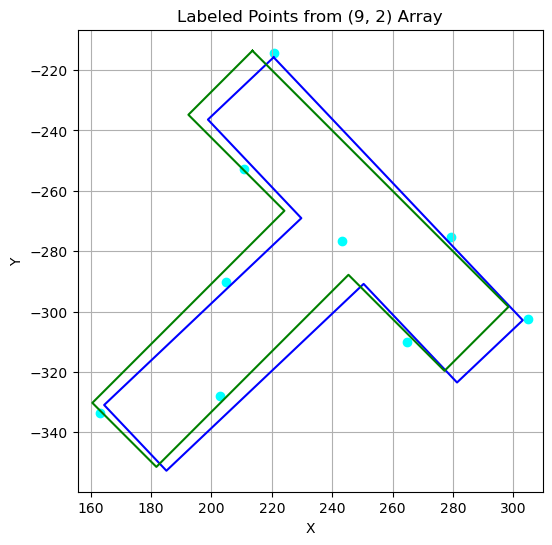

In [7]:
states = get_element_by_idx(data_v1, "state", 0)
state = states[-1]
curr = get_tee((state[2], state[3]), state[4])
kp = get_element_by_idx(data_v1, "keypoint", 0)[-1]
plot_kp(np.array(curr.exterior.coords), np.array(get_goal().exterior.coords), kp)

In [8]:
import os
from tqdm import tqdm

def generate_videos(data, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    prev = 0
    episode_ends = data["meta"]["episode_ends"][:]
    for i in tqdm(range(episode_ends.shape[0])):
        curr = int(episode_ends[i])
        imgs = data["data"]["img"][prev:curr]
        imgs = np.array(imgs, dtype=np.uint8)
        imageio.mimsave(os.path.join(output_dir, f"gt_{i}.gif"), imgs, fps=30)
        prev = curr


generate_videos(data_v1, "data/data_v1_videos")
generate_videos(data_v2, "data/data_v2_videos")


100%|██████████| 206/206 [00:32<00:00,  6.34it/s]


In [9]:
from IPython.display import display, HTML

def display_gifs(path: str, per_col: int = 8, indices: Optional[Sequence[int]] = None):
    video_files = [os.path.join(path, p) for p in os.listdir(path) if p.endswith(".gif")]
    per_col = 8
    video_paths = [[]]

    if indices is not None:
        indices = set(indices)
    else:
        indices = set(range(len(video_files)))

    for i, f in enumerate(video_files):
        if i not in indices:
            continue
        video_paths[-1].append(f)
        if len(video_paths[-1]) >= per_col:
            video_paths.append([])

    # Define dimensions
    video_width = 128
    video_height = 128

    # Build HTML table
    html = "<table style='border-spacing: 10px;'>"

    for row in video_paths:
        html += "<tr>"
        for gif_path in row:
            html += f"""
            <td>
                <img src="{gif_path}" width="{video_width}" height="{video_height}" />
            </td>
            """
        html += "</tr>"

    html += "</table>"

    # Display the video matrix
    display(HTML(html))


In [10]:
display_gifs("data/data_v1_videos")

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,


In [11]:
display_gifs("data/data_v2_videos/", indices=v2_exclusives)

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
